# Quantitative Developer Exercise -- Volatility Calculation

Author: Ross Gales, 10/2/2023

- Four files are provided representing price data for four stocks (A, B, C, and D). Each row represents a point of trade and the price.

- The assigned task is to estimate the volatility of each stock over the period (measured in percentage annualised volatility of returns).

- There are biases and errors that require cleaning.

- The code should be designed to run automatically and unsupervised as part of a scheduled set of tasks.

- Time assigned: 3-4 hours

In [12]:
# !pip install pandas
# !pip install matplotlib

## Data exploration

First, the data is explored to understand the format. We look at the dataframe shape, head and date range for the first dataset.

In [15]:
from os import listdir
from os.path import isfile, join

data_path = 'prices'
files = [f for f in listdir(data_path) if isfile(join(data_path, f))]

In [16]:
import pandas as pd

df = pd.read_csv(join(data_path, files[0]))

# Check size
print(df.shape)

# Print sample
df.head()

(69588, 2)


,ts,price
0,2017-03-01 08:00:00.000000000,10272.0
1,2017-03-01 08:00:07.100371456,10272.0
2,2017-03-01 08:00:09.575620352,10270.0
3,2017-03-01 08:00:41.278088704,10270.0
4,2017-03-01 08:01:00.903632640,10260.0


In [17]:
# Read in df again with date parsing on col=0
df = pd.read_csv(join(data_path, files[0]), parse_dates=[0])

# Check date range of first dataframe
print('Earliest trade: ', df['ts'].min())
print('Latest trade: ', df['ts'].max())

print('Timespan: ', df['ts'].max()-df['ts'].min())

Earliest trade:  2017-03-01 08:00:00
Latest trade:  2017-08-18 15:58:41.258860032
Timespan:  170 days 07:58:41.258860032


## Visualisation

We can then read in all four datasets and visualise each series as a time series. We are interested in characterising the data -- e.g. identifying the scope of volatility, existence of outliers, comparing the key differences in datasets signifying behaviour that must be considered in later calculations.

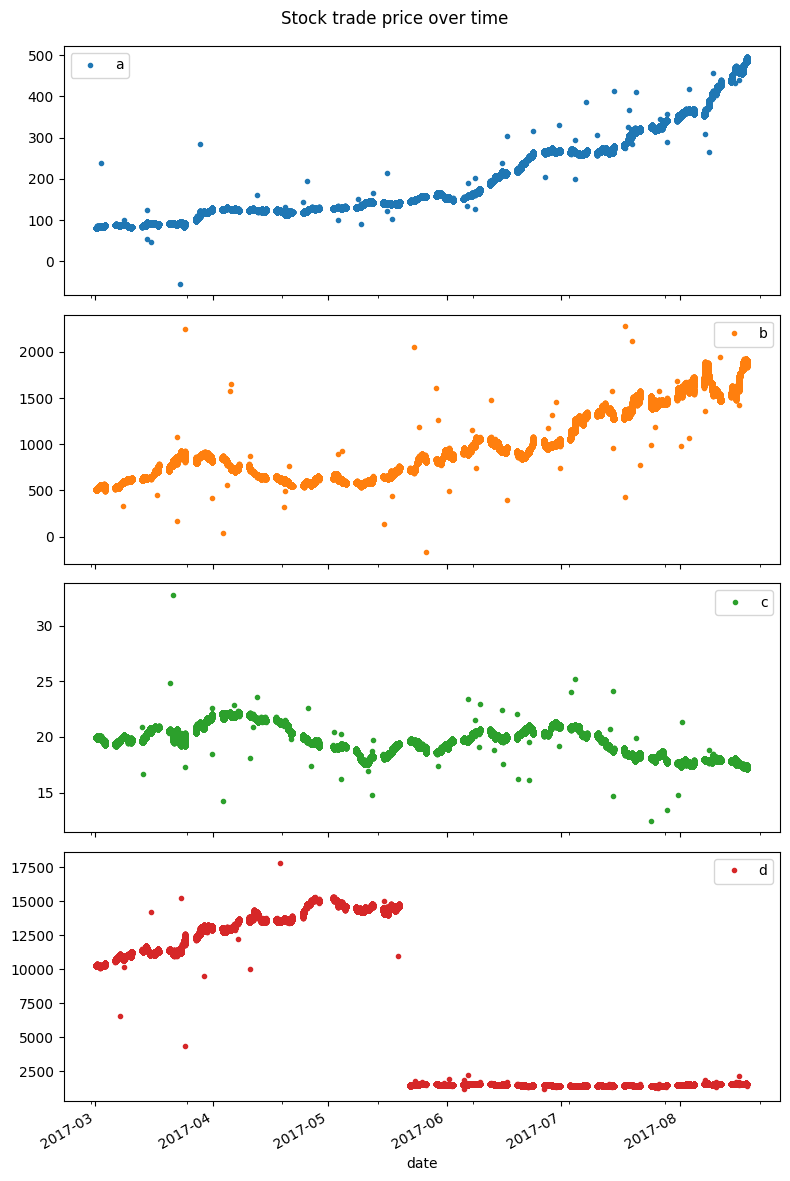

In [21]:
# Combine into single dataframe and plot for viz analysis.
# Scatter used over line as line graph obfuscates outliers and hides inactive periods (i.e. weekends)

df = pd.DataFrame()

for f in files:
    dft = pd.read_csv(join(data_path, f), parse_dates=[0])
    
    # Normalise price for comparison
    # dft['price'] = (dft['price'] - dft['price'].min()) / (dft['price'].max() - dft['price'].min())

    # stock_name = 'stock ' + f.split('_')[-1].split('.')[0]
    stock_name = f.split('_')[-1].split('.')[0]
    
    dft = dft.rename(columns = {'price':stock_name})

    if df.shape[0] > 0:
        df = df.merge(dft, on='ts', how='outer', sort=True)
    else:
        df = dft


ax = df.plot(
  kind="line", 
  x='ts', 
  y=['a', 'b', 'c', 'd'],
  subplots = True,
  # layout=(2,2)
  sharex = True, 
  ls="none", 
  marker=".",
  figsize=(8,12),
  title='Stock trade price over time',
  xlabel='date')[0]

fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)

Some key observations are made:
- The y axis is shared between figures, so the date range for each dataset appears uniform.
- There are clear periodic gaps, signifying weekends in which no trading can occur.
- Outliers clearly exist. The negative values seen in stocks a and b show that at least a number of these must be errors in data entry.
- there is a clear change in behaviour at the mid point for stock d, which requires further handling.
- Stock c appears to show increasing levels of volatility over time. Whether this is significant is dependent upon domain requirements and is explored later.

The next steps are therefore:
- Develop method to identify and handle outliers.
- Consider implications of change in character (e.g. stock d) and handle.
- Measure volatility.
- Consider measuring changes in volatility over time.


## Outlier Detection

We are interested primarily in _additive outliers_ which are defined as a type of outlier which does not affect the trend within the data and typically caused by data entry or human error. 

_Innovative outliers_ cause temporary changes in the trends. While these may be present within the data and therefore a viable target for identification and elimination, they were not visually apparent and therefore exploring whether they are present within the data was outside the scope of this report. Discussion with domain experts is recommended to clarify the extent of this class of outlier and therefore the importance with which they are addressed.

Finally, _level shifts_ imply a permanent change in the mean. This is exemplified in stock d and explored in a later section.

It is important to note that outlier detection is an ongoing area of research and the methods used in this report are constrained by the time allotted for the assignment and should therefore not be considered definitive. Further work developing and validating these approaches for real-world implementations is warranted.

### Two-sided median method

We use the two-sided median method of outlier detection: for a given point in time, $y_t$, the median value $m_t^{(k)}$ is computed within a $2k$ neighbourhood of point $y_t$ (that is, a distance of $k$ to either side of $y_t$). The absolute difference between $y_t$ and the median is then compared and, where the difference exceeds a threshold $\tau$, $y_t$ is identified as an outlier. 

Outliers are typically replaced with the median value $m_t^{(k)}$ to maintain the integrity of the time series, though a the intervals are irregular in this applicaion, they are simply removed.

This method is documented in Sabyasachi and Meckesheimer (2007) and expands upon a method by Pearson (2002), which uses a median over the entire dataset. The neighbourhood median was preferred here due to the significant trends present within the data. 

For live outlier detection, a _one-sided median method_ is applicable, which calculates the median using only values occurring prior to $y_t$. Given the dataset encapsulates a historical 170 day period, this method was not used here except in the most recent cases where $k$ future values are not available.


### Additive Outlier Removal

We can test the detection method on the first dataframe with arbitrary values set for $k$ and $\tau$. In the first instance, we use a $k$ of 7 days (thus a 14-day window) and add the median to the dataframe.

Note that the 7 days is based on precise timing rather than complete days of trading.

Values of $k$ which are not a multiple of 7 (and low enough to remain significant) should account for the weekends, in which no trades are made, such that a single side of the window is not underrepresented.

Due to the irregular nature of the trades, calculating the median based on timing is not as algorithmically straight forward as a regular series.

In [6]:
import numpy as np
from datetime import timedelta

df = pd.read_csv(join(data_path, files[1]), parse_dates=[0])


def calc_med(df, k):
    col_med = 'median_k'+str(k)
    col_diff = 'median_k'+str(k)+'_diff'

    df[col_med] = np.nan
    df[col_diff] = np.nan

    for index, row in df.iterrows():

        min_i = max(index-k, 0)
        max_i = min(df.shape[0]-1, index+k)
        median = df.iloc[min_i:max_i+1]['price'].median()

        # Get median value for k-days neighbourhood of row:
        # median = df.loc[(df['ts'] > time-timedelta(days=k)) & \
        #         (df['ts'] < time+timedelta(days=k))]['price'].median()
        
        df.at[index,col_med] = median
        df.at[index,col_diff] = abs(median - df.iloc[index]['price'])
    
    return df



k=7
df = calc_med(df, k)


We can then compare the smoothed median time series to the recorded values. The third line represents the absolute difference between the data point and median.

<AxesSubplot: xlabel='ts'>

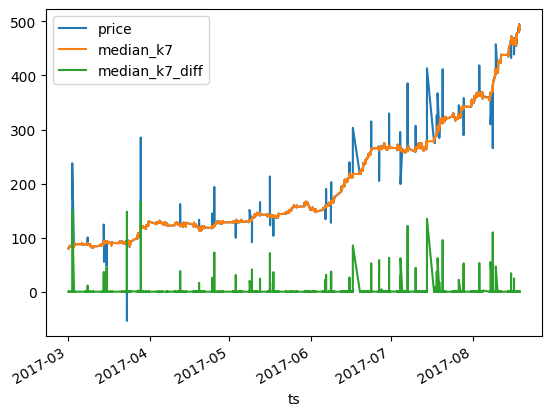

In [60]:
df.plot(x='ts', y=['price', 'median_k'+str(k), 'median_k'+str(k)+'_diff'])

We can therefore decide on the threshold by which to classify outliers. In this report, we have set the threshold as 3 standard deviations from the mean difference from the median. These values are removed and the figure from the initial visualisation is recreated with outlier removal applied:

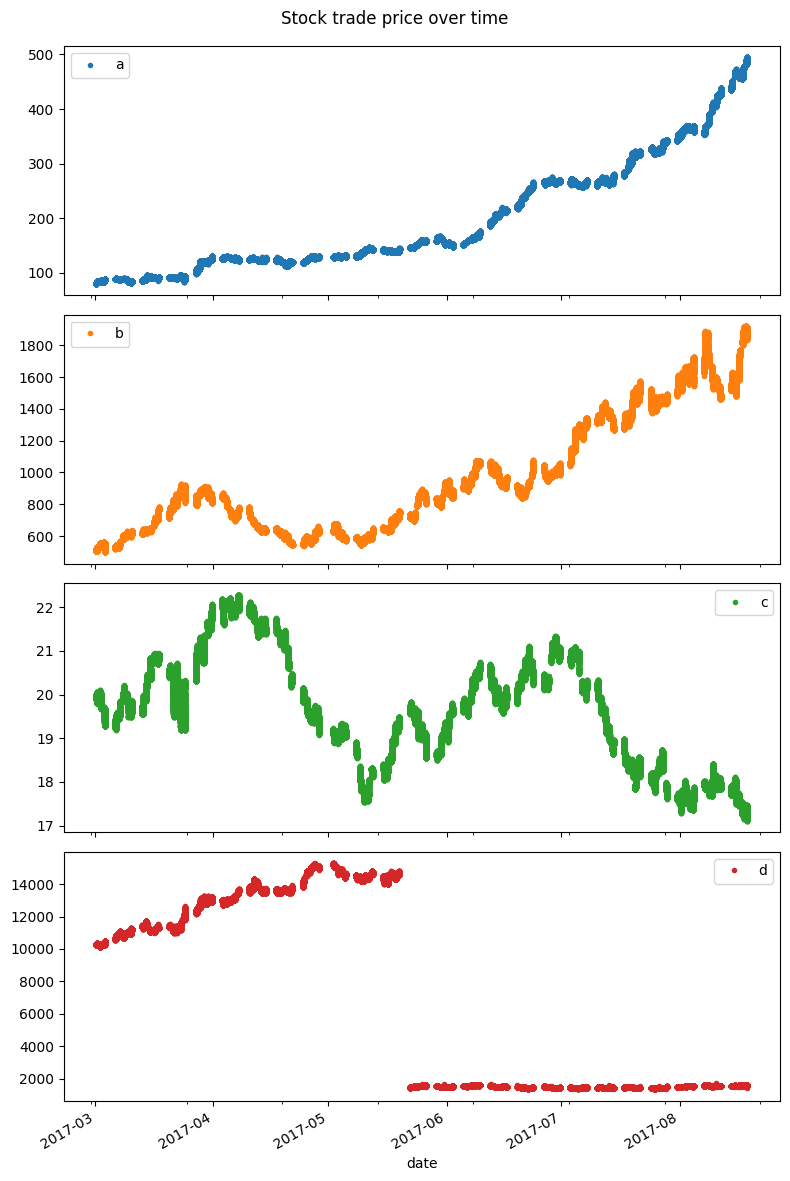

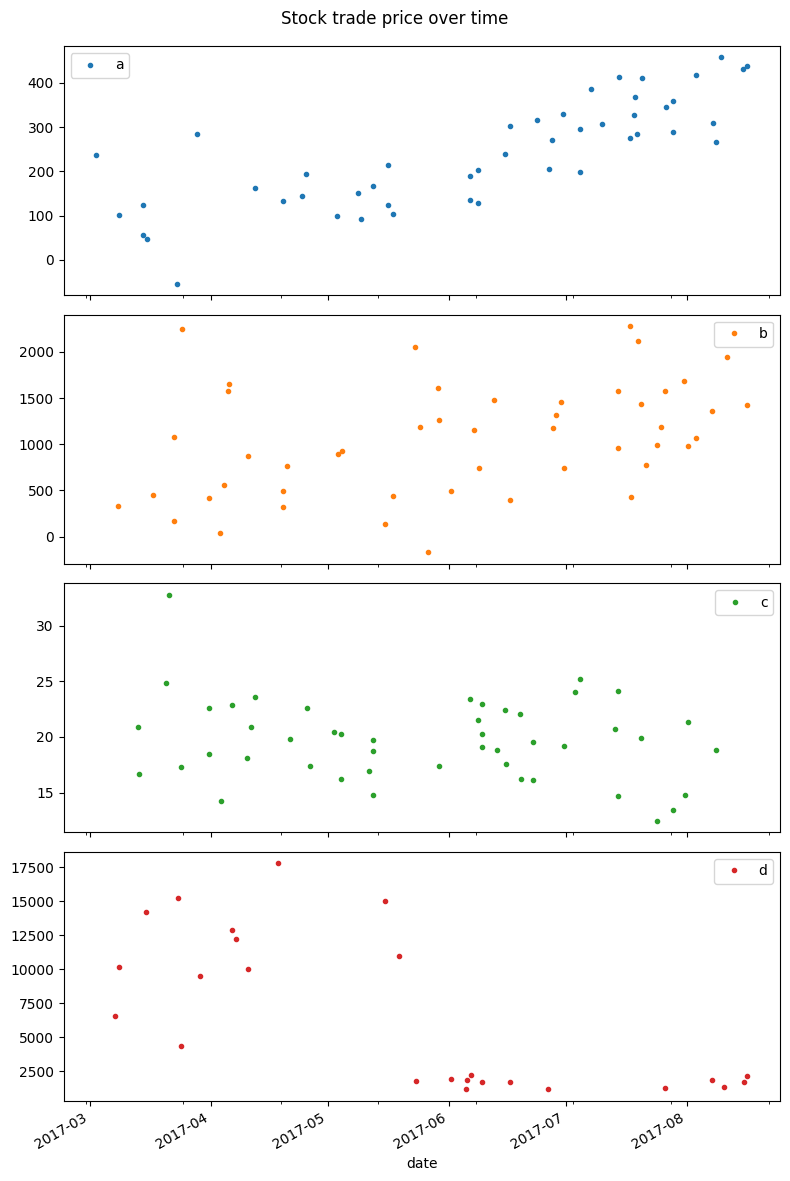

In [211]:

df = pd.DataFrame()
df2 = pd.DataFrame()

for f in files:
    dft = pd.read_csv(join(data_path, f), parse_dates=[0])
    
    # Normalise price for comparison
    # dft['price'] = (dft['price'] - dft['price'].min()) / (dft['price'].max() - dft['price'].min())

    # stock_name = 'stock ' + f.split('_')[-1].split('.')[0]
    stock_name = f.split('_')[-1].split('.')[0]
    
    # Calculate median
    k = 7
    dft = calc_med(dft, k)

    # Remove outliers within 3 std def of error:
    col_diff = 'median_k'+str(k)+'_diff'
    dft2 = dft.loc[dft[col_diff] >= 3 * dft[col_diff].std()] # for checking
    dft = dft.loc[dft[col_diff] < 3 * dft[col_diff].std()]
    dft2 = dft2.reset_index()
    dft = dft.reset_index()
    
    # Drop exta cols prior to merge
    dft2 = dft2[['ts', 'price']]
    dft = dft[['ts', 'price']]
    
    dft2 = dft2.rename(columns = {'price':stock_name})
    dft = dft.rename(columns = {'price':stock_name})

    if df.shape[0] > 0:
        df2 = df2.merge(dft2, on='ts', how='outer', sort=True)
        df = df.merge(dft, on='ts', how='outer', sort=True)
    else:
        df2 = dft2
        df = dft


ax = df.plot(
  kind="line", 
  x='ts', 
  y=['a', 'b', 'c', 'd'],
  subplots = True, 
  sharex = True, 
  ls="none", 
  marker=".",
  figsize=(8,12),
  title='Stock trade price over time',
  xlabel='date')[0]

fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)


ax2 = df2.plot(
  kind="line", 
  x='ts', 
  y=['a', 'b', 'c', 'd'],
  subplots = True, 
  sharex = True, 
  ls="none", 
  marker=".",
  figsize=(8,12),
  title='Stock trade price over time',
  xlabel='date')[0]

fig2 = ax2.get_figure()
fig2.tight_layout()
fig2.subplots_adjust(top=0.95)

### Level Shift Detection 
A level shift is clearly evident in stock d at the mid point of the time series. After this shift, the mean price and volatility change significantly and therefore re-evaluating such measures after the shift poing is recommended. This, however, was not part of the assignment specification so has not been performed here. The relevance of implementing such a process is left for future work pending a discussion with domain experts.

## Volatility Calculation

We calculate volatility according to the formula: Annualised Volatility = Standard Deviation * √252

First, the rate of return between each trade is calculated. The rate of return is plotted to detect significant changes in values.


Volatility for stock d = 6.1%
Volatility for stock a = 1.4%
Volatility for stock c = 0.96%
Volatility for stock b = 3.0%


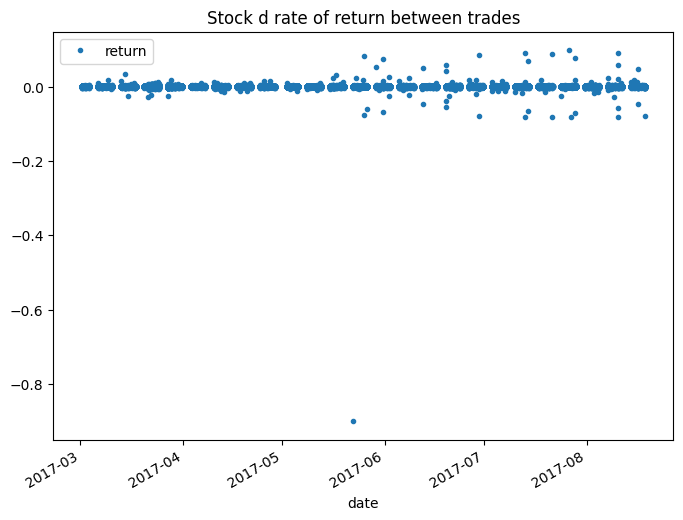

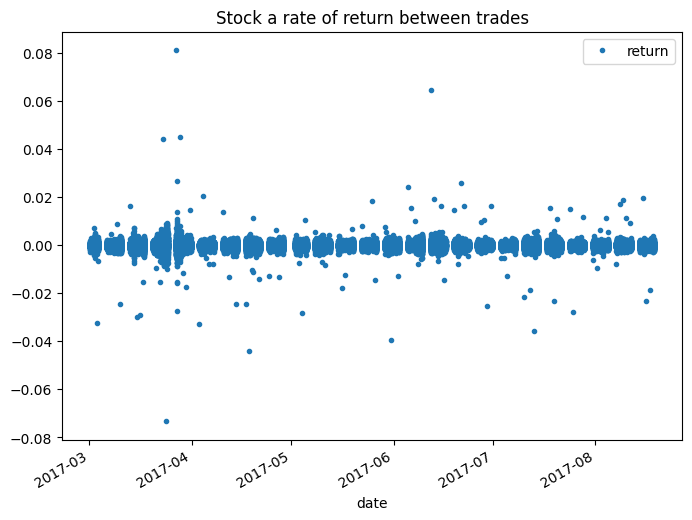

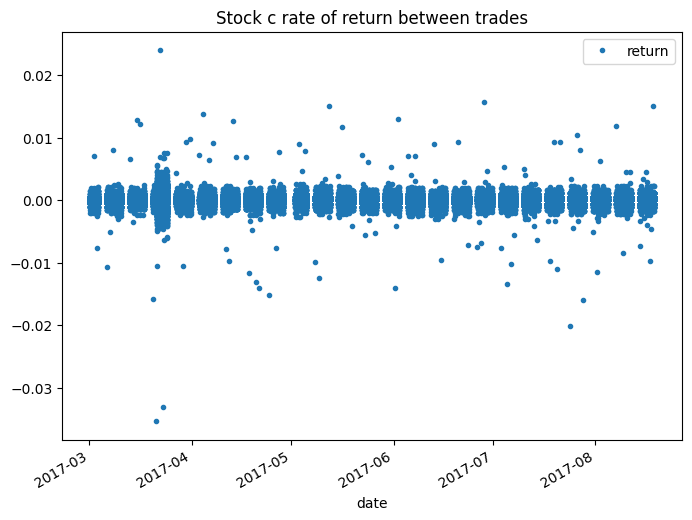

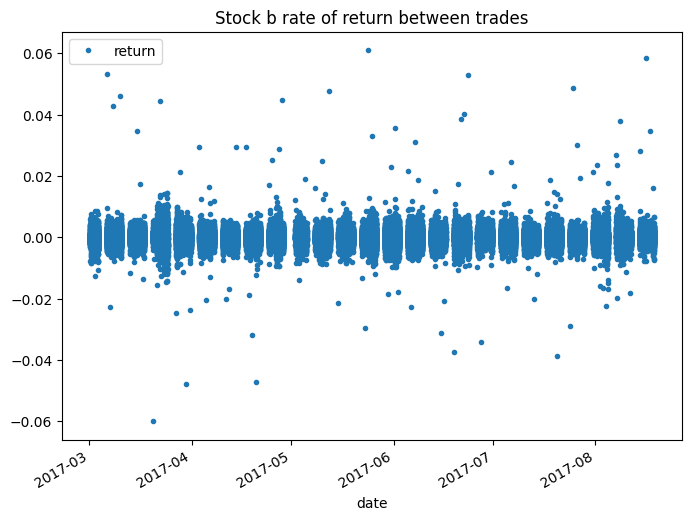

In [156]:
import math

for f in files:
    dft = pd.read_csv(join(data_path, f), parse_dates=[0])
    
    stock_name = f.split('_')[-1].split('.')[0]
    
    # Calculate median
    k = 7
    dft = calc_med(dft, k)

    # Remove outliers within 3 std def of error:
    col_diff = 'median_k'+str(k)+'_diff'
    dft = dft.loc[dft[col_diff] < 3 * dft[col_diff].std()]
    dft = dft[['ts', 'price']]
    dft = dft.reset_index()
    
    dft = dft.rename(columns = {'price':stock_name})

    # Calculate returns
    dft['return'] = np.nan
    for i, row in dft.iterrows():
        if i == 0:
            continue
        dft.at[i, 'return'] = dft.iloc[i][stock_name]/dft.iloc[i-1][stock_name]-1

    # Calculate volatility
    vol = dft['return'].std() * math.sqrt(252)
    print('Volatility for stock {} = {:.2}%'.format(stock_name, vol*100))


    dft.plot(
        kind="line", 
        x='ts', 
        y='return',
        ls="none", 
        marker=".",
        figsize=(8,6),
        title='Stock {} rate of return between trades'.format(stock_name),
        xlabel='date')


We then repeat the calculation for daily returns, using the latest trade of each day as the daily rate.

Annualised daily volatility for stock d = 149.3%
Annualised daily volatility for stock a = 145.9%
Annualised daily volatility for stock c = 31.61%
Annualised daily volatility for stock b = 221.1%


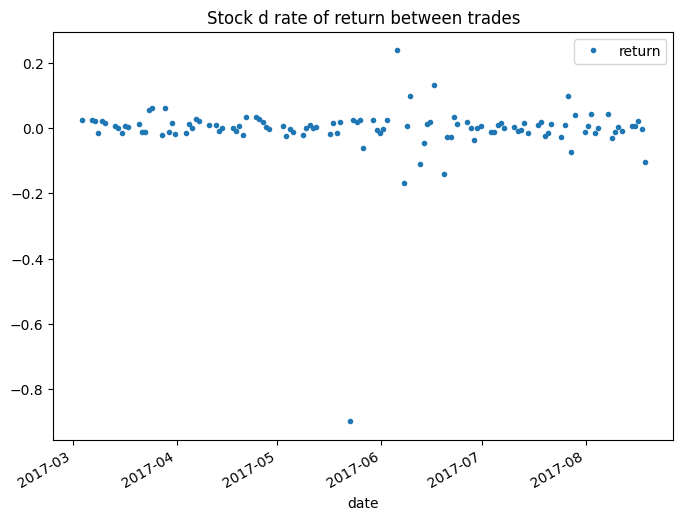

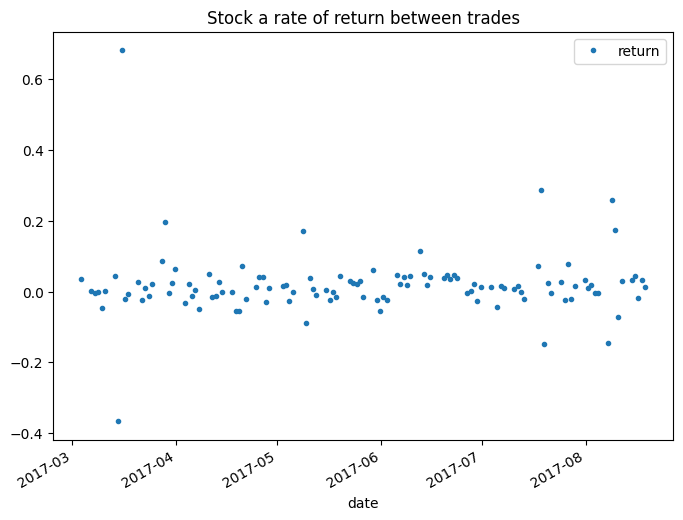

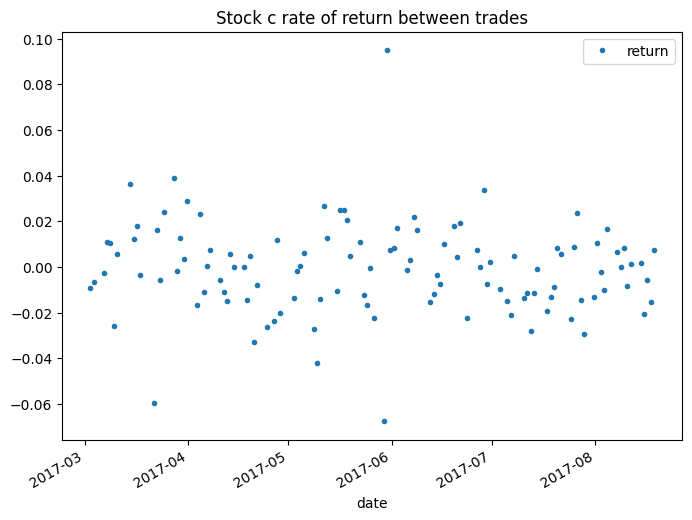

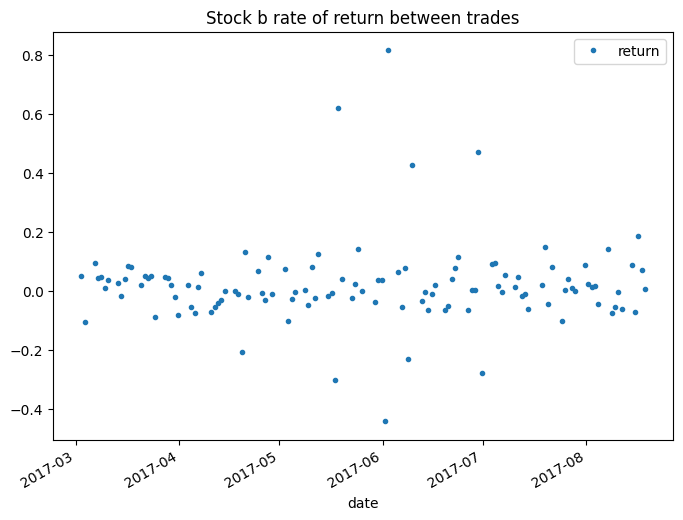

In [31]:
import math

for f in files:
    
    stock_name = f.split('_')[-1].split('.')[0]
    
    dft = pd.read_csv(join(data_path, f), parse_dates=[0])

    # Select latest trade from each day as closing price:
    dft = dft.groupby(pd.Grouper(key='ts', axis=0, 
                      freq='1D', sort=True)).tail(1).dropna()
    dft = dft.reset_index()

    
    # Calculate median
    k = 5
    dft = calc_med(dft, k)

    # Remove outliers within 3 std def of error:
    col_diff = 'median_k'+str(k)+'_diff'
    dft = dft.loc[dft[col_diff] < 3 * dft[col_diff].std()]
    dft = dft[['ts', 'price']]
    dft = dft.reset_index()
    
    dft = dft.rename(columns = {'price':stock_name})

    # Calculate returns
    dft['return'] = np.nan
    for i, row in dft.iterrows():
        if i == 0:
            continue
        return_val = dft.iloc[i][stock_name]/dft.iloc[i-1][stock_name]-1
        
        dft.at[i, 'return'] = return_val

    # Calculate volatility
    vol = dft['return'].std() * math.sqrt(252)
    print('Annualised daily volatility for stock {} = {:.4}%'.format(stock_name, vol*100))


    dft.plot(
        kind="line", 
        x='ts', 
        y='return',
        ls="none", 
        marker=".",
        figsize=(8,6),
        title='Stock {} rate of return between trades'.format(stock_name),
        xlabel='date')


## Further Work
- If this process is to be performed every day (and small gains in efficiency are relevant), outlier detection can be performed once per time window and stored to the source data files rather than recalculating each day. 
- This code assumes data will always be in a format matching the files given. A robust implementation for use in an automated pipeline should have additional conformity checks.
- The level shift in stock d has not been handled (per the assignment specification) but it is likely this has relevance to the end users and warrants further exploration.
- Changes in volatility over time should be more effectively evaluated given the assumption that recent behaviour is more relevant to the end users. See the increased volatility in stock d after the level shift as an example. This was not specified by the assignment but should be discussed with end users and domain experts. This can be handled using a similar neighbourhood trend detection approach.
- The choice to use the last observed trade as the closing price warrants further discussion with domain experts.
- The one-week neighbourhood for median calculation is arbitrary and can be optimised. As can the 3-std threshold for outlier detection.

## References

Basu, Sabyasachi, and Martin Meckesheimer. "Automatic outlier detection for time series: an application to sensor data." Knowledge and Information Systems 11 (2007): 137-154.

Pearson RK (2002) Data mining in the face of contaminated and incomplete records. In: Second SIAM conference on data mining, Arlington, VA